#6 month Sales forecasting using Prophet model

In [ ]:
!pip install prophet


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('cleaned_superstore.csv')
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         9994 non-null   int64  
 1   order_id       9994 non-null   object 
 2   order_date     9994 non-null   object 
 3   ship_date      9994 non-null   object 
 4   ship_mode      9994 non-null   object 
 5   customer_id    9994 non-null   object 
 6   customer_name  9994 non-null   object 
 7   segment        9994 non-null   object 
 8   country        9994 non-null   object 
 9   city           9994 non-null   object 
 10  state          9994 non-null   object 
 11  postal_code    9994 non-null   int64  
 12  region         9994 non-null   object 
 13  product_id     9994 non-null   object 
 14  category       9994 non-null   object 
 15  sub-category   9994 non-null   object 
 16  product_name   9994 non-null   object 
 17  sales          9994 non-null   float64
 18  quantity

In [ ]:
# For forecasting, we need only Order Date and Sales
df['order_date'] = pd.to_datetime(df['order_date'])

monthly_sales = df.groupby(pd.Grouper(key='order_date', freq='M')).agg({'sales': 'sum'}).reset_index()
monthly_sales.columns = ['ds', 'y']  # Prophet needs 'ds' and 'y'


/tmp/ipython-input-3095021164.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='order_date', freq='M')).agg({'sales': 'sum'}).reset_index()


In [ ]:
from prophet import Prophet

model = Prophet()
model.fit(monthly_sales)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpohzlzelj/g727rfb6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpohzlzelj/fpzl6vah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21797', 'data', 'file=/tmp/tmpohzlzelj/g727rfb6.json', 'init=/tmp/tmpohzlzelj/fpzl6vah.json', 'output', 'file=/tmp/tmpohzlzelj/prophet_modelf0uqahxg/prophet_model-20250806041341.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:13:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:13:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [ ]:
from prophet.plot import plot_plotly
plot_plotly(model, forecast)


In [ ]:
forecast[['ds','yhat']].to_csv("forecast_sales.csv", index=False)

#RFM Customer Segmentation

In [ ]:
# Load data and parse dates
df['order_date'] = pd.to_datetime(df['order_date'])
snapshot_date = df['order_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'sales': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']


In [ ]:
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

In [ ]:
rfm['Segment'] = rfm['RFM_Score'].apply(lambda x: 'High Value' if x >= 9 else ('Mid Value' if x >= 6 else 'Low Value'))

In [ ]:
rfm

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,AA-10315,185,5,5563.560,1,1,4,6,Mid Value
1,AA-10375,20,9,1056.390,4,4,1,9,High Value
2,AA-10480,260,4,1790.512,1,1,2,4,Low Value
3,AA-10645,56,6,5086.935,3,2,4,9,High Value
4,AB-10015,416,3,886.156,1,1,1,3,Low Value
...,...,...,...,...,...,...,...,...,...
788,XP-21865,44,11,2374.658,3,4,3,10,High Value
789,YC-21895,5,5,5454.350,4,2,4,10,High Value
790,YS-21880,10,8,6720.444,4,4,4,12,High Value
791,ZC-21910,55,13,8025.707,3,4,4,11,High Value


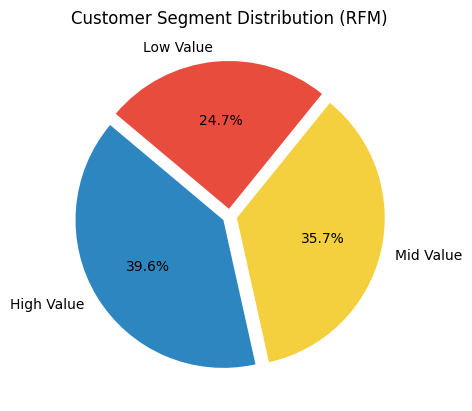

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#2E86C1','#F4D03F','#E74C3C'],
                                       startangle=140, explode=[0.05,0.05,0.05])
plt.ylabel("")
plt.title("Customer Segment Distribution (RFM)")
plt.show()

In [ ]:
# Ensure only the required columns are saved
rfm[['customer_id', 'Segment']].to_csv("rfm_segments.csv",
                                       index=False,  # Removes index
                                       header=True)  # Ensures proper headers

In [ ]:
print(rfm[['customer_id', 'Segment']].head())  # Preview first rows
print(rfm[['customer_id', 'Segment']].columns) # Check headers

  customer_id     Segment
0    AA-10315   Mid Value
1    AA-10375  High Value
2    AA-10480   Low Value
3    AA-10645  High Value
4    AB-10015   Low Value
Index(['customer_id', 'Segment'], dtype='object')
